# 3 
Copy the code from the MNIST section and the MLP section. When trying to run the code, it will complain about functions and classes that it can't find. These are functions and classes defined in the Softmax Regression section. Simply copy those as well :)

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

torch.manual_seed(42)
np.random.seed(42)

In [2]:
import torch
import torchvision
from torchvision import transforms

# `ToTensor()` converts the image data from PIL type to 32-bit floating point
# tensors. It also divides all numbers by 255, so that all pixel values are between
# 0 and 1
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [3]:
def get_fashion_mnist_labels(labels):
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [4]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    plt.tight_layout()
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

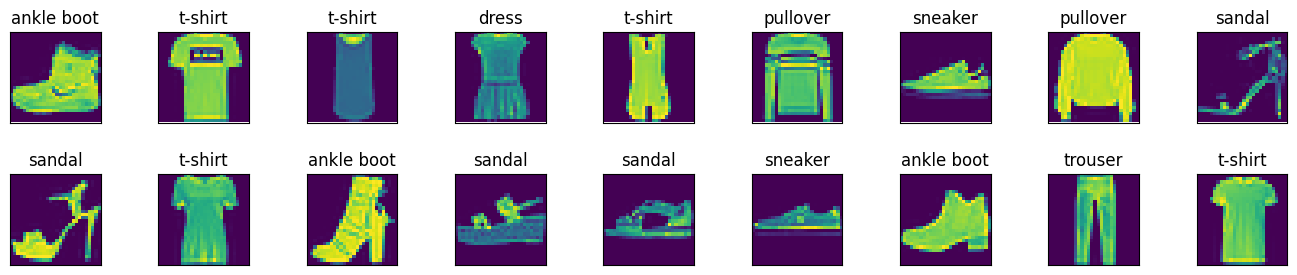

In [5]:
X, y = next(iter(torch.utils.data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

We don't set the batch size here because it gets overwritten later. This doesn't really do anything so we could delete it:

In [6]:
batch_size = 256

# Use 2 processes to read the data.
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=2)

Make sure to set number of training images to `45000` and number of validation images to `15000`:

In [7]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [45000, 15000],
                                                           generator=torch.Generator().manual_seed(42))
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_val, batch_size, shuffle=False,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

We need to use `2` hidden layers. This means we need `2` `nn.Linear` layers. 

**Important**: the final linear layer is not a hidden layer. It is the output layer. So we need a total of `3` linear layers to have `2` hidden layers. If you think this classification of layers into hidden layers and output layers is stupid and useless, then so do I :)

We need to use the hyperbolic tangent activation function instead of the ReLU, so we replace `nn.ReLU()` with `nn.Tanh()`.

We also need a dropout layer with dropout probability `40%`, so we use a `nn.Dropout(0.4)`:

Finally we apply Xavier initialization using `nn.init.xavier_uniform_`, and set the biases to `0` using `nn.init.zeros_`:

In [8]:
net = nn.Sequential(nn.Flatten(),
                    # hidden layer
                    nn.Linear(784, 256),
                    nn.Tanh(),
                    nn.Dropout(0.4),
                    # hidden layer
                    nn.Linear(256, 256),
                    nn.Tanh(),
                    nn.Dropout(0.4),
                    # output layer
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Tanh()
  (3): Dropout(p=0.4, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): Tanh()
  (6): Dropout(p=0.4, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

In [9]:
def train(net, train_iter, val_iter, loss, num_epochs, optimizer):
    """Train a model."""
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

In [10]:
def train_epoch(net, train_iter, loss, optimizer):  
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training correct predictions, no. of examples
    total_loss = 0
    total_hits = 0
    total_samples = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += float(l)
        total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
        total_samples += y.numel()
    # Return training loss and training accuracy
    return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100

In [11]:
def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = net(X)
            l = loss(y_hat, y)
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100

Here we set the batch size, learning rate and number of epochs as requested in the exercise:

In [12]:
batch_size, lr, num_epochs = 512, 0.15, 10
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size)
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, loss, num_epochs, optimizer)

Epoch 1, Train loss 0.87, Train accuracy 68.57, Validation loss 0.58, Validation accuracy 79.25
Epoch 2, Train loss 0.61, Train accuracy 78.05, Validation loss 0.54, Validation accuracy 79.63
Epoch 3, Train loss 0.55, Train accuracy 80.31, Validation loss 0.50, Validation accuracy 81.90
Epoch 4, Train loss 0.53, Train accuracy 81.04, Validation loss 0.48, Validation accuracy 82.70
Epoch 5, Train loss 0.51, Train accuracy 81.92, Validation loss 0.47, Validation accuracy 83.47
Epoch 6, Train loss 0.49, Train accuracy 82.32, Validation loss 0.45, Validation accuracy 84.04
Epoch 7, Train loss 0.48, Train accuracy 82.73, Validation loss 0.46, Validation accuracy 83.94
Epoch 8, Train loss 0.47, Train accuracy 83.14, Validation loss 0.44, Validation accuracy 84.21
Epoch 9, Train loss 0.46, Train accuracy 83.52, Validation loss 0.43, Validation accuracy 84.77
Epoch 10, Train loss 0.46, Train accuracy 83.57, Validation loss 0.48, Validation accuracy 82.63


Loss and accuracy plots are not requested in the exercise, but doesn't hurt to do them :)

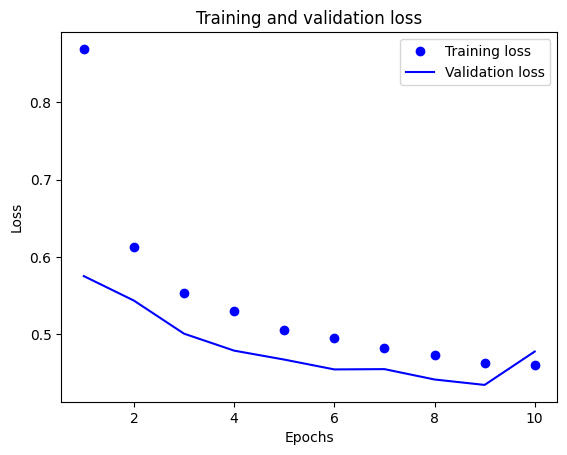

In [14]:
def plot_loss(train_loss_all, val_loss_all):
    epochs = range(1, len(train_loss_all) + 1) 
    plt.plot(epochs, train_loss_all, 'bo', label='Training loss') 
    plt.plot(epochs, val_loss_all, 'b', label='Validation loss') 
    plt.title('Training and validation loss') 
    plt.xlabel('Epochs') 
    plt.ylabel('Loss') 
    plt.legend()  
    plt.show()

plot_loss(train_loss_all, val_loss_all)

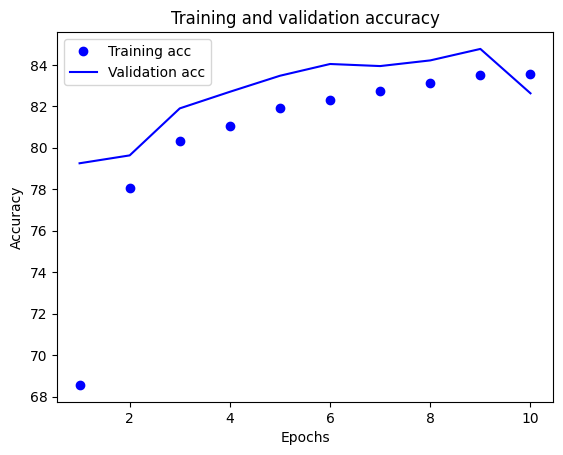

In [15]:
def plot_accuracy(train_acc_all, val_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_all, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs') 
    plt.ylabel('Accuracy') 
    plt.legend()
    plt.show()

plot_accuracy(train_acc_all, val_acc_all)

This is the evaluation of the model on the test set:

In [16]:
test_loss, test_acc = evaluate_accuracy(net, test_iter)
print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

Test loss 0.50, Test accuracy 81.58
